### Approaches to Solving MDPs II: Monte Carlo Simulation

### University of Virginia
### Reinforcement Learning
#### Last updated: February 4, 2024

---


### SOURCES 

- Reinforcement Learning, RS Sutton & AG Barto, 2nd edition. Chapter 5
- Mastering Reinforcement Learning with Python, Enes Bilgin. Chapter 5

### LEARNING OUTCOMES

- Apply Monte Carlo simulaton to estimate value functions
- Understand the strengths and limitations of Monte Carlo methods
- Explain the purpose of exploring starts
- Understand why importance sampling is needed for off-policy learning

### CONCEPTS

- Monte Carlo simulation can be used to measure value functions without knowledge of transition probabilities
- Exploring starts
- Simulation risk
- On-policy and off-policy methods
- Importance sampling


---  

### Monte Carlo (MC) Methods

MC does not require complete knowledge of the environment.

Instead, it relies on sampling by simulating many trajectories, where a trajectory looks like: $s_t,a_t,r_{t+1},s_{t+1},a_{t+1},r_{t+2},s_{t+2},...,r_T,s_T$

For measuring state value function $v_\pi(s)$ and action value function $q_\pi(s,a)$,  
- start with $s$ in the former and $s, a$ in the latter  
- generate many sample trajectories: sequences of state-action-reward tuples
- compute the mean

**MC is an approximation**: while the true values would require infinite simulated trajectories, we can get *close enough* by simulating a massive number of paths.

MC makes updates when trajectories are completed.

**Exploring Starts**

One challenge with computing $q_\pi(s,a)$ by simulation is that many state-action pairs $(s,a)$ may not be visited  
Can force a given $(s,a)$ by starting an episode in that condition; called **exploring starts.**

Here is the algorithm from Sutton and Barto:

![mc_es](./mc_es.png)

**Comparison to Dynamic Programming**

DP uses one-step transitions and it calculates expectations of taking various paths

MC uses full paths for making updates

Backup diagram is simpler than DP: chain of state-action-state-action ... leading to final state.

White circles are states, black circles are actions.

<img src="./mc_backup_diagram.png" width=40>

**Independence**

Estimates for each state in MC are independent. This makes it embarrisingly parallel.

---

### Blackjack!

Next we simulate blackjack to study policies and values. If we wanted to use DP, this would be very hard as transition probabilities need to be computed in advance. 

![basic_strategy](./blackjack_basic_strategy.jpg)

#### Blackjack Policy Simulator

The object of the game is to obtain cards with total value as great as possible without exceeding 21 and beat the dealer.

The rules:

- Face card (Jack/Queen/King) values are 10
- Ace value is 1 or 11. When player has option of either value, ace is called *usable*.
- Two cards are dealt to player and dealer
- One of the dealer's cards is face up
- If the player has 21 and the dealer doesn't, the player wins
- If the player has 21 and the dealer has 21, it is a draw
- If the player does not have 21, he can draw cards until he stops (sticks) or exceeds 21 (goes bust)
- If he goes bust, he loses
- If he sticks, it is the dealer's turn
- The dealer must stick on a sum of 17 or greater and hits otherwise
- If the dealer goes bust, the player wins. Otherwise, the winner has final sum closer to 21.

Assumption

- infinite card deck

Policy

- a simple policy we can consider: player sticks if sum greater than *max_total_hit*, else hits  

A more complete policy will choose based on 1) sum of player cards 2) dealer card shown 3) player having usable aces

**Question:** Based on these three variables, how many possible states are there?

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [17]:
class CardGenerator():
    def __init__(self):
        self.card_values = [2,3,4,5,6,7,8,9,10,11]
        self.weights=[1/13]*8 + [4/13] + [1/13]

    def draw_card(self):
        return random.choices(self.card_values, self.weights)[0]

In [18]:
class BasePlayer():
    def __init__(self, verbose, name):
        self.verbose     = verbose
        self.name        = name
        self.total       = 0
        self.usable_aces = 0
        self.card_gen    = CardGenerator()
        self.is_busted   = False
        
        # draw two cards and manage aces
        new_card = self.card_gen.draw_card()
        if self.verbose:
            print(self.name)
            print('card1', new_card)
        self.total += new_card
        self.manage_possible_ace(new_card)
        new_card = self.card_gen.draw_card()
        if self.verbose:
            print('card2', new_card)
        self.total += new_card
        self.manage_possible_ace(new_card)
        
    def manage_possible_ace(self, new_card):
        if new_card == 11:
            if self.total > 21:
                self.total -= 10
            else:
                self.usable_aces += 1

    def is_over21(self):
        if self.total > 21:
            if self.usable_aces > 0:
                self.total -= 10
                self.usable_aces -= 1
            else:
                self.is_busted = True
    
    def report_status(self):
        print('total', self.total)
        print('usable_aces', self.usable_aces)
        print('is_busted',self.is_busted)
        print('\n')
        

In [19]:
class Player(BasePlayer):
    def __init__(self, verbose, name, max_total_hit):
        super().__init__(verbose, name)
        self.max_total_hit = max_total_hit
        
        if self.verbose:
            self.report_status()

    def followup_play(self):
        while self.total <= self.max_total_hit: 
            print(self.name, 'draws a card...')
            new_card = self.card_gen.draw_card()
            self.total += new_card  
            self.manage_possible_ace(new_card)   
            self.is_over21()
            if self.verbose:
                print('new_card', new_card)
                self.report_status()


In [20]:
def compare_end(player, dealer):
    #print('player total', player.total)
    #print('dealer total', dealer.total)
    
    if player.total > dealer.total:
        return 1
    elif player.total == dealer.total:
        return 0
    else:
        return -1
    
def player_vs_dealer(player, dealer): 
    
    if player.total == 21:
        if dealer.total != 21:
            return 1
        elif dealer.total == 21:
            return 0
    else:
        player.followup_play()
        if player.is_busted:
            print(player.name, 'busted')
            return -1
        else:
            dealer.followup_play()
            if dealer.is_busted:
                print(dealer.name, 'busted')
                return 1
            else:
                return compare_end(player, dealer)
                

#### Briefly review the code for understanding

#### 1. Testing the card generator

First, create a card generator and use it to draw cards.

To test whether it seems to generate values with the correct probabilities, draw 10,000 cards, keeping track of the frequency of each value. Does it seem to be working properly? You might increase the number of draws and repeat.

#### 2. Simulate a hand of blackjack

Review how the hand plays out and validate that it works properly

In [22]:
verbose = True
max_total_hit = 18

plr = Player(verbose, 'Austin Powers', max_total_hit)
dealer = Player(verbose, 'Number Two', 16)

reward = player_vs_dealer(plr, dealer)
print('reward:', reward)

Austin Powers
card1 7
card2 10
total 17
usable_aces 0
is_busted False


Number Two
card1 11
card2 5
total 16
usable_aces 1
is_busted False


Austin Powers draws a card...
new_card 10
total 27
usable_aces 0
is_busted True


Austin Powers busted
reward: -1


#### 3. Simulate a large number of hands for various *max_total_hit* and compute mean reward for each

Player draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Player draws a card...
Dealer draws a card...
Dealer draws a card...
Dealer busted
Dealer draws a card...
Dealer draws a car

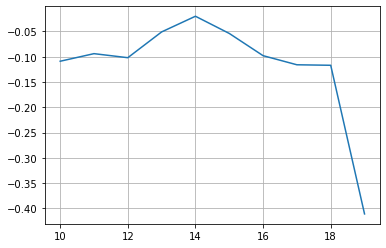

In [25]:
its = 1000

thresholds = np.arange(10,20)
mean_rewards = np.empty(len(thresholds))

ix = 0
for thresh in thresholds:
    sum_rewards = 0
    for it in range(its):
        plr = Player(False, 'Player', thresh)
        dealer = Player(False, 'Dealer', 16)
        sum_rewards += player_vs_dealer(plr, dealer)
    mean_rewards[ix] = sum_rewards/its
    ix += 1

plt.plot(thresholds, mean_rewards)
plt.grid()
plt.show()

This gives understanding of value of different policies: at which sum should player stick

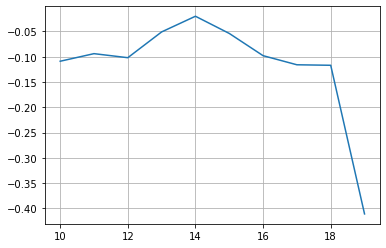

In [26]:
plt.plot(thresholds, mean_rewards)
plt.grid()
plt.show()

#### 4. Policy to account for dealer upcard 

How can you can modify the code to allow the policy to additionally depend on the dealer upcard? Test it here and discuss if the results make sense.

#### 5. Policy: player sticks on sum 19-21 and hits otherwise

Consider a policy where the player sticks on sum 19-21 and hits otherwise.  
How might you estimate the value of this policy given a state where player sum is 13 and dealer upcard is 5?

#### 6. Measuring value of state combinations

If you wish to measure the value of various state combinations (player starting sum, dealer upcard, player usable aces), how can this be done efficiently?

### On-Policy versus Off-Policy

Two approaches to select all actions infinitely often: 

- on-policy methods: learns the value of the optimal policy based on agent's actions

Agent commits to always exploring and tries to find best policy that still explores  
Earlier, we learned an example: $\epsilon$-greedy policies

- off-policy methods: learns the value of the optimal policy independently of the agent's actions

This uses two policies: 

1) policy for learning, which becomes optimal policy. Called the *target policy*

2) policy that is exploratory and used for generating behavior. Called the *behavior policy*

We will discuss these methods further throughout the course


The policies will be functions. For off-policy methods, there will be a function (e.g., a neural network) for the target policy, and another for the behavior policy.

**Off policy Example:**  
target policy - Agent visits Joe's Shanghai for best dumplings, and Grimaldi's for best pizza. This is optimal from experience. But is it really best? The policy can be informed by the behavior policy and updated.

behavior policy - Agent applies policy above, but will randomly explore from each state 5\% of the time. These learnings feed the target policy.


### Off-policy and Importance Sampling

Given target policy $\pi$ and behavior policy $b$

Want to use episodes from $b$ to estimate values for $\pi$ 

General problem is that we use a random variable with one distribution to compute expected value with a different distribution.

We need to adjust by a ratio of the probabilities involving $\frac{\pi(a|s)}{b(a|s)}$

Since ${b(a|s)}$ is in denominator, we need assumption of *coverage*:

Any possible event for $\pi$  must be possible for $b$. In terms of policies, $\pi(a|s)>0$ implies $b(a|s)>0$.  

**Importance Sampling (IS) Ratio**:

$\rho_{t:T-1} = \prod_{k=t}^{T-1} \frac{\pi(a_k|s_k)}{b(a_k|s_k)}$

Computationally, the gains $G$ from MC simulated paths must be weighted by the IS ratio. This amounts to adjusting the expected value.

See Sutton and Barto Chapter 5 for more details and *weighted importance sampling*.

---

#### Limitations to Monte Carlo

- Need to wait for a trajectory to be finalized before value update can be made.  
Example: you estimate commute time before the trip starts. Midway into the trip, you realize you're running 30 minutes late.  
You can't update your estimate until you finish the trip. Is this realistic? Can you do better?

- The simulated environment needs to match reality: **simulation risk**  
If there is a gap between simulated environment and reality, the model may fail in deployment.

For these reasons, there was a push to develop better approaches such as temporal-difference methods.  
We discuss these next.

---